In [82]:
import pandas as pd 
import numpy as np

Data Import and Data cleaning

In [83]:
df = pd.read_csv('recipe_reviews.csv')

In [84]:
print('shape:', df.shape)
print('columns:', list(df.columns))
print(df.head(10))

shape: (18182, 24)
columns: ['Unnamed: 0', 'recipe_number', 'recipe_code', 'likes_score', 'dislike_index', 'response_level', 'user_index', 'ranking_value', 'vote_ratio', 'score_log', 'region', 'device_type', 'recipe_name', 'comment_id', 'user_id', 'user_name', 'user_score', 'created_at', 'responses', 'likes', 'dislikes', 'ranking_score', 'text', 'stars']
   Unnamed: 0  recipe_number  recipe_code  likes_score  dislike_index  \
0           0              1        14299     0.104335      -0.087082   
1           1              1        14299     6.970958      -0.094496   
2           2              1        14299     3.136047      -0.047194   
3           3              1        14299     2.319913      -0.107932   
4           4              1        14299     6.950816       0.142649   
5           5              1        14299     2.950819       1.046363   
6           6              1        14299    11.331714      -0.085230   
7           7              1        14299    28.161200     

In [85]:
df.isna().sum().sort_values(ascending=False)

text              2
Unnamed: 0        0
recipe_code       0
recipe_number     0
dislike_index     0
response_level    0
user_index        0
likes_score       0
ranking_value     0
vote_ratio        0
region            0
score_log         0
recipe_name       0
comment_id        0
user_id           0
device_type       0
user_name         0
user_score        0
responses         0
created_at        0
likes             0
dislikes          0
ranking_score     0
stars             0
dtype: int64

In [86]:
text_col = df.select_dtypes(include='object').columns
for col in text_col:
    df[col] = df[col].astype(str).str.strip()
    df.loc[df[col] == '2', col] = np.nan
    
print(df.isna().sum().sort_values(ascending=False))

Unnamed: 0        0
recipe_number     0
recipe_code       0
likes_score       0
dislike_index     0
response_level    0
user_index        0
ranking_value     0
vote_ratio        0
score_log         0
region            0
device_type       0
recipe_name       0
comment_id        0
user_id           0
user_name         0
user_score        0
created_at        0
responses         0
likes             0
dislikes          0
ranking_score     0
text              0
stars             0
dtype: int64


In [87]:
df.duplicated().sum()

np.int64(0)

In [88]:
categorical_cols = ['region', 'device_type']

before_summary = {}
for col in categorical_cols:
    uniques = df[col].dropna().unique()
    if len(uniques) <= 10:
        before_summary[col] = list(uniques) 

for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].str.replace(r'\s+', ' ', regex=True)
    df[col] = df[col].str.lower()
    
after_summary = {}
for col in categorical_cols:
    uniques = df[col].dropna().unique()
    if len(uniques) <= 10:
        after_summary[col] = list(uniques)
        
summary_df = pd.DataFrame({
    'before': pd.Series(before_summary),
    'after': pd.Series(after_summary)
}).reset_index().rename(columns={'index': 'column'})
print(summary_df)

        column                      before                       after
0       region  [North, West, South, East]  [north, west, south, east]
1  device_type   [Tablet, Mobile, Desktop]   [tablet, mobile, desktop]


In [89]:
df = df.loc[:, ~df.columns.str.contains(r'^Unnamed', case=False)]


In [90]:
num_cols = [c for c in df.select_dtypes(include='number').columns if c != 'stars'] 
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outlier_mask = (df[num_cols] < lower) | (df[num_cols] > upper)
print("Outliers per column:\n", outlier_mask.sum().sort_values(ascending=False))


Outliers per column:
 ranking_score     4180
vote_ratio        4080
likes             4080
ranking_value     3956
likes_score       2878
dislikes          2396
dislike_index     2394
created_at        1487
score_log         1246
user_score        1246
user_index        1168
recipe_code        656
response_level     330
responses          230
recipe_number        0
dtype: int64


In [91]:
medians = df[num_cols].median()

for col in num_cols:
    outliers = (df[col] < lower[col]) | (df[col] > upper[col])
    df.loc[outliers, col] = medians[col]
    
print("Outliers after treatment:\n", ((df[num_cols] < lower) | (df[num_cols] > upper)).sum().sort_values(ascending=False))

Outliers after treatment:
 recipe_number     0
recipe_code       0
likes_score       0
dislike_index     0
response_level    0
user_index        0
ranking_value     0
vote_ratio        0
score_log         0
user_score        0
created_at        0
responses         0
likes             0
dislikes          0
ranking_score     0
dtype: int64


In [92]:
print(df.dtypes)

recipe_number       int64
recipe_code         int64
likes_score       float64
dislike_index     float64
response_level    float64
user_index        float64
ranking_value     float64
vote_ratio        float64
score_log         float64
region             object
device_type        object
recipe_name        object
comment_id         object
user_id            object
user_name          object
user_score          int64
created_at          int64
responses           int64
likes               int64
dislikes            int64
ranking_score       int64
text               object
stars               int64
dtype: object


In [93]:
categorical_cols = ['region', 'device_type']
for col in categorical_cols:
    df[col] = df[col].astype('category')
    
id_cols = ['recipe_code', 'recipe_number', 'recipe_name', 'comment_id', 'user_id', 'user_name']
for col in id_cols:
    df[col] = df[col].astype('string') 
    
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

assert 'stars' in df.columns, "Target column 'stars' missing."
df['stars'] = pd.to_numeric(df['stars'], errors='coerce').clip(1, 5)
df = df.dropna(subset=["stars"]).copy()
df["stars"] = df["stars"].astype(int)


print(df.dtypes)

recipe_number     string[python]
recipe_code       string[python]
likes_score              float64
dislike_index            float64
response_level           float64
user_index               float64
ranking_value            float64
vote_ratio               float64
score_log                float64
region                  category
device_type             category
recipe_name       string[python]
comment_id        string[python]
user_id           string[python]
user_name         string[python]
user_score                 int64
created_at        datetime64[ns]
responses                  int64
likes                      int64
dislikes                   int64
ranking_score              int64
text                      object
stars                      int64
dtype: object


In [94]:
df.to_csv('recipe_reviews_cleaned.csv', index=False)

In [95]:
dataframe = pd.read_csv('recipe_reviews_cleaned.csv')
dataframe.head()

,recipe_number,recipe_code,likes_score,dislike_index,response_level,user_index,ranking_value,vote_ratio,score_log,region,...,user_id,user_name,user_score,created_at,responses,likes,dislikes,ranking_score,text,stars
0,1,14299,0.104335,-0.087082,-0.001580,1.172032,102.660964,0.0,0.693147,north,...,u_9iFLIhMa8QaG,Jeri326,1,1970-01-01 00:00:01.622717707,0,0,0,100,"I tweaked it a little, removed onions because ...",5
1,1,14299,0.078797,-0.094496,-0.002169,1.040708,102.660964,0.0,0.693147,west,...,u_Lu6p25tmE77j,Mark467,1,1970-01-01 00:00:01.622717707,0,0,0,100,Bush used to have a white chili bean and it ma...,5
2,1,14299,0.078797,-0.047194,0.014539,1.040708,102.660964,0.0,0.693147,north,...,u_s0LwgpZ8Jsqq,Barbara566,1,1970-01-01 00:00:01.622717707,0,0,0,100,I have a very complicated white chicken chili ...,5
3,1,14299,0.078797,-0.107932,0.000193,0.865812,102.660964,0.0,0.693147,south,...,u_fqrybAdYjgjG,jeansch123,1,1970-01-01 00:00:01.622717707,0,0,0,100,"In your introduction, you mentioned cream chee...",1
4,1,14299,0.078797,0.142649,0.000193,1.040708,102.660964,0.0,0.693147,north,...,u_XXWKwVhKZD69,camper77,1,1970-01-01 00:00:01.622717707,0,0,0,100,Wonderful! I made this for a &#34;Chili/Stew&#...,1


Exploratory Data Analysis (EDA) and Visualization

In [96]:
print("Rows, columns:", df.shape)

num_cols = df.select_dtypes(include=['number']).columns
print("summary Statistics for numeric columns:\n", df[num_cols].describe().T)

if 'stars' in df.columns:
    print("\nStars value counts:", df['stars'].value_counts().sort_index())

print(df[col].value_counts(dropna=False))

Rows, columns: (18182, 23)
summary Statistics for numeric columns:
                   count        mean           std         min         25%  \
likes_score     18182.0    0.072639  2.907433e-01   -0.805890   -0.096429   
dislike_index   18182.0    0.003183  1.610609e-01   -0.530184   -0.099268   
response_level  18182.0    0.000056  6.649649e-03   -0.018695   -0.004465   
user_index      18182.0    0.999262  4.820285e-01   -0.426352    0.682446   
ranking_value   18182.0  100.899253  6.906603e+00   75.487900   96.813702   
vote_ratio      18182.0    0.000000  0.000000e+00    0.000000    0.000000   
score_log       18182.0    0.693147  1.110254e-16    0.693147    0.693147   
user_score      18182.0    1.000000  0.000000e+00    1.000000    1.000000   
responses       18182.0    0.000000  0.000000e+00    0.000000    0.000000   
likes           18182.0    0.000000  0.000000e+00    0.000000    0.000000   
dislikes        18182.0    0.000000  0.000000e+00    0.000000    0.000000   
ranking_

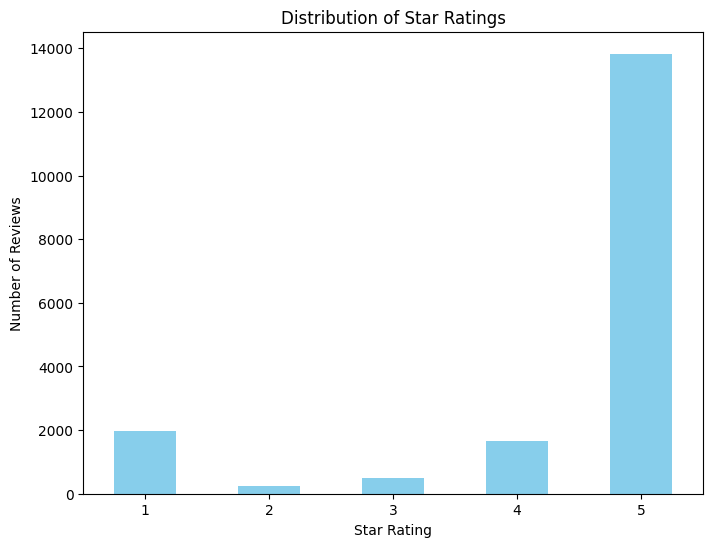

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
df['stars'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

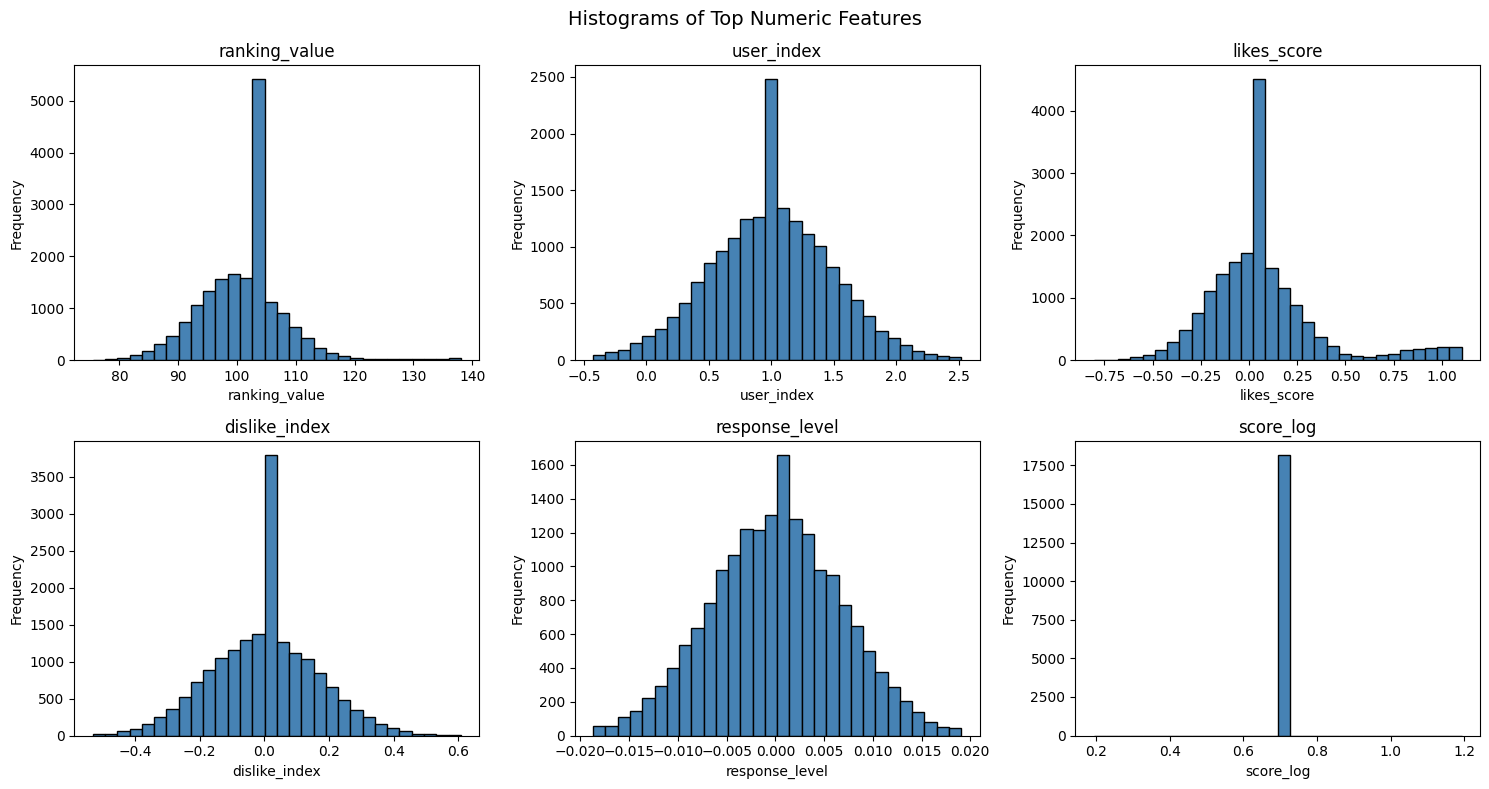

In [98]:
num_cols = df.select_dtypes(include=[np.number]).columns.drop('stars', errors='ignore')
top_by_var = df[num_cols].var().sort_values(ascending=False).head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(15,8))  # 2 rows × 3 columns
axes = axes.flatten()

for i, col in enumerate(top_by_var):
    axes[i].hist(df[col].dropna(), bins=30, color='steelblue', edgecolor='black')
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

plt.suptitle("Histograms of Top Numeric Features", fontsize=14)
plt.tight_layout()
plt.show()

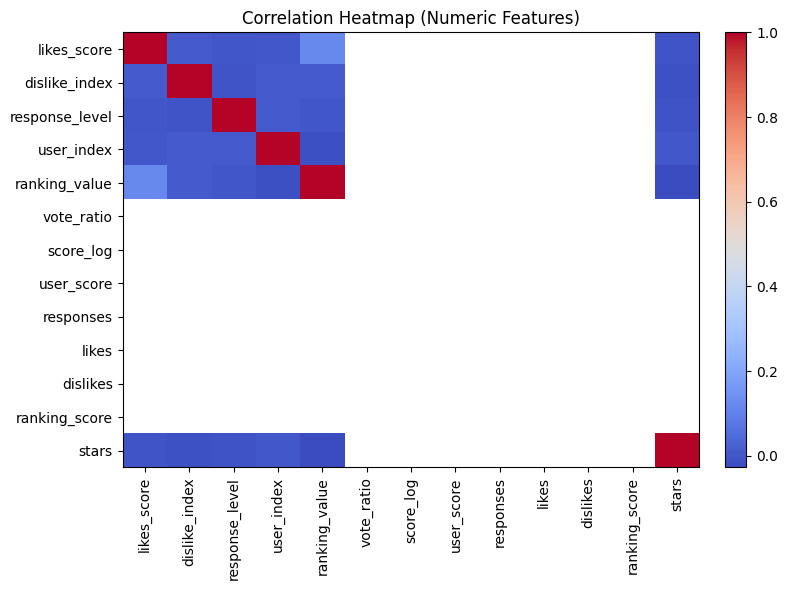

In [99]:
num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr(method='pearson')

fig = plt.figure(figsize=(8,6))
im = plt.imshow(corr, cmap='coolwarm', interpolation='nearest', aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

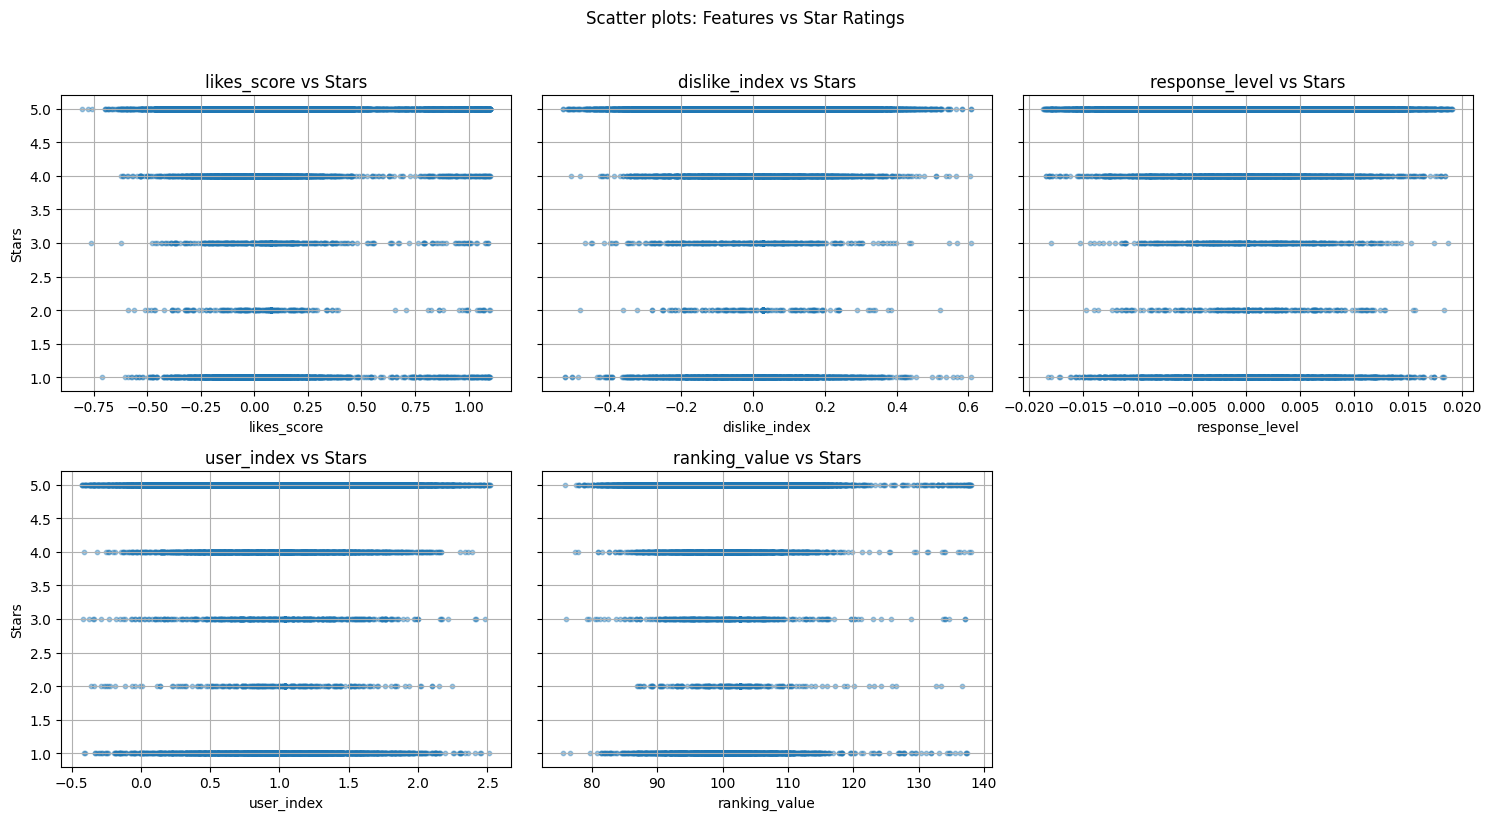

In [100]:
import math
TOPK = 6         
COLS = 3          

feat_list = [c for c in num_cols if c != "stars" and df[c].nunique(dropna=True) > 1][:TOPK]

ROWS = math.ceil(len(feat_list) / COLS)
fig, axes = plt.subplots(ROWS, COLS, figsize=(5*COLS, 4*ROWS), sharey=True)
axes = np.atleast_1d(axes).ravel()
plot_df = df.copy()

for i, col in enumerate(feat_list):
    ax = axes[i]
    ax.scatter(plot_df[col], plot_df['stars'], alpha=0.4, s=10)
    ax.set_title(f'{col} vs Stars')
    ax.set_xlabel(col)
    if i % COLS == 0:
        ax.set_ylabel('Stars')
    ax.grid(True)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Scatter plots: Features vs Star Ratings', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


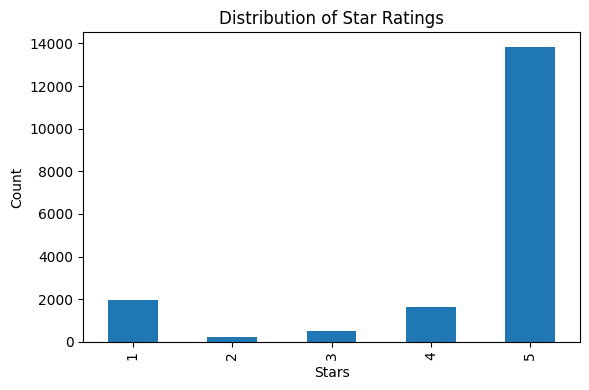

In [101]:
plt.figure(figsize=(6,4))
df['stars'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Star Ratings')
plt.xlabel('Stars'); plt.ylabel('Count')
plt.tight_layout(); plt.show()


Top numeric↔stars (Spearman):
 dislike_index    -0.021
ranking_value    -0.018
response_level   -0.011
user_index        0.009
likes_score       0.001
dtype: float64


C:\Users\aenap\AppData\Local\Temp\ipykernel_32612\701351860.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=levels, showfliers=False)


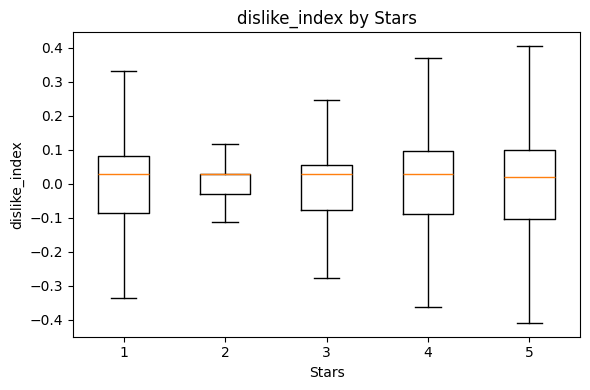

C:\Users\aenap\AppData\Local\Temp\ipykernel_32612\701351860.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=levels, showfliers=False)


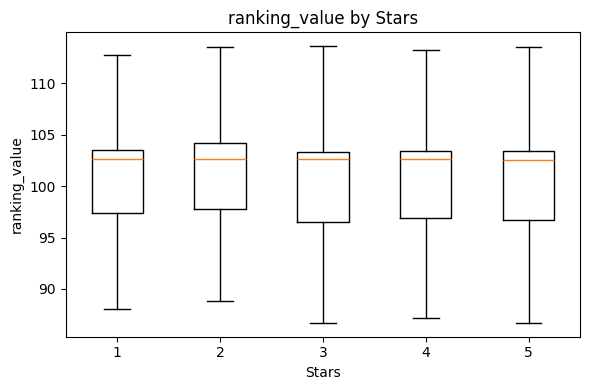

C:\Users\aenap\AppData\Local\Temp\ipykernel_32612\701351860.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=levels, showfliers=False)


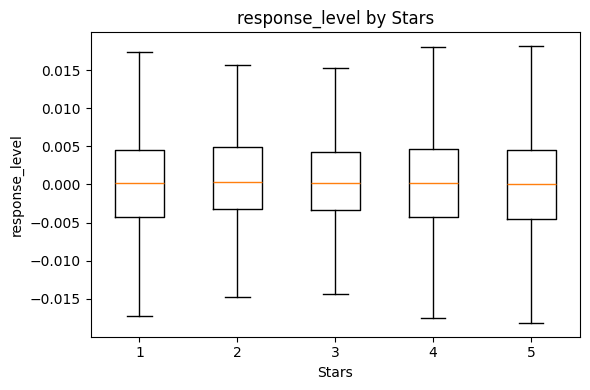

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

stars = pd.to_numeric(df['stars'], errors='coerce').clip(1,5)
df = df.loc[stars.notna()].copy()
df['stars'] = stars.astype(int)

num_feats = [c for c in df.select_dtypes(include=[np.number]).columns if c != 'stars' and df[c].nunique(dropna=True) > 1]
spearman = pd.Series({c: df[c].corr(df['stars'], method='spearman') for c in num_feats}).dropna()
print("Top numeric↔stars (Spearman):\n", spearman.sort_values(key=lambda s: s.abs(), ascending=False).head(10).round(3))

top3 = spearman.abs().sort_values(ascending=False).head(3).index.tolist()
levels = sorted(df['stars'].unique())
for col in top3:
    data = [df.loc[df['stars']==k, col].dropna().values for k in levels]
    plt.figure(figsize=(6,4))
    plt.boxplot(data, labels=levels, showfliers=False)
    plt.title(f'{col} by Stars')
    plt.xlabel('Stars')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


C:\Users\aenap\AppData\Local\Temp\ipykernel_32612\1845864073.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (df.groupby(cat)['stars'].mean()


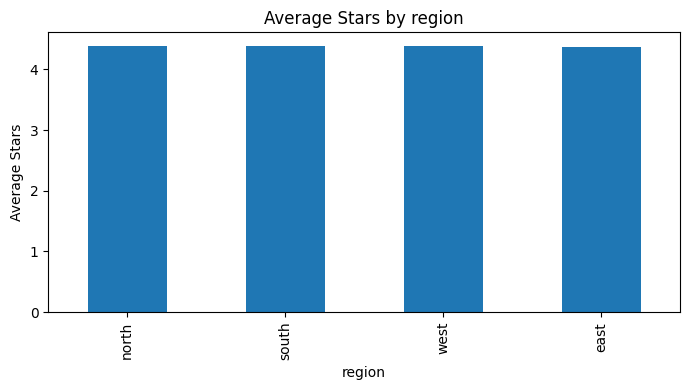

C:\Users\aenap\AppData\Local\Temp\ipykernel_32612\1845864073.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (df.groupby(cat)['stars'].mean()


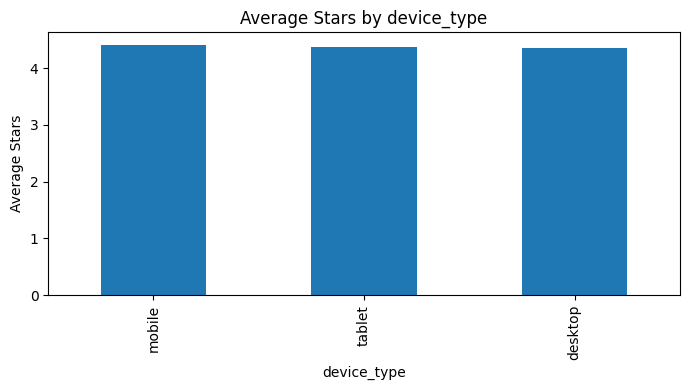

In [103]:
import matplotlib.pyplot as plt

for cat in [c for c in ['region','device_type'] if c in df.columns]:
    plt.figure(figsize=(7,4))
    (df.groupby(cat)['stars'].mean()
    .sort_values(ascending=False)
    .round(2)
    .plot(kind='bar'))
    plt.title(f'Average Stars by {cat}')
    plt.xlabel(cat); plt.ylabel('Average Stars')
    plt.tight_layout(); plt.show()


Feature Engineering and Model Building

In [104]:
%pip install -U scikit-learn
import sklearn
print("scikit-learn version:", sklearn.__version__)


Note: you may need to restart the kernel to use updated packages.
scikit-learn version: 1.7.2



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [105]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Build X, y (drop high-cardinality/ID-like)
drop_ids = {'comment_id','user_id','user_name','recipe_name'}
X = df.drop(columns=[c for c in drop_ids if c in df.columns] + ['stars'], errors='ignore')
y = df['stars']

text_col = 'text' if 'text' in X.columns else None
cat_cols = [c for c in ['region','device_type'] if c in X.columns]
num_cols_model = X.select_dtypes(include=[np.number]).columns.tolist()

transformers = []
if num_cols_model:
    transformers.append(('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                                        ('scaler', StandardScaler())]), num_cols_model))
if cat_cols:
    transformers.append(('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols))
if text_col:
    transformers.append(('txt', TfidfVectorizer(max_features=1200, ngram_range=(1,2), min_df=5), text_col))

preprocessor = ColumnTransformer(transformers, remainder='drop', verbose_feature_names_out=False)

pipe_lr = Pipeline([('prep', preprocessor),
                    ('clf', LogisticRegression(max_iter=500, multi_class='multinomial', class_weight='balanced'))])

pipe_rf = Pipeline([('prep', preprocessor),
                    ('clf', RandomForestClassifier(n_estimators=200, random_state=42,
                                                class_weight='balanced_subsample', n_jobs=-1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)


c:\Users\aenap\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


Model Evaluation


[Logistic Regression] Acc=0.5703  Prec=0.3284  Rec=0.4396  F1=0.3467
              precision    recall  f1-score   support

           1      0.257     0.443     0.325       395
           2      0.096     0.277     0.143        47
           3      0.183     0.429     0.257        98
           4      0.204     0.435     0.278       331
           5      0.901     0.615     0.731      2766

    accuracy                          0.570      3637
   macro avg      0.328     0.440     0.347      3637
weighted avg      0.738     0.570     0.625      3637



<Figure size 500x500 with 0 Axes>

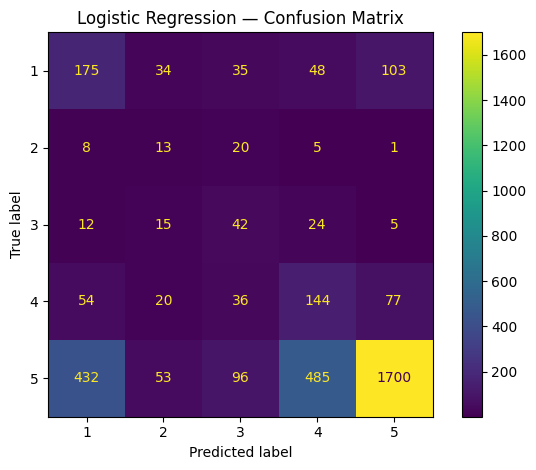

[Logistic Regression] ROC-AUC (macro OVR): 0.7729

[Random Forest] Acc=0.7674  Prec=0.9079  Rec=0.2272  F1=0.2263
              precision    recall  f1-score   support

           1      0.773     0.043     0.082       395
           2      1.000     0.043     0.082        47
           3      1.000     0.031     0.059        98
           4      1.000     0.021     0.041       331
           5      0.767     0.999     0.867      2766

    accuracy                          0.767      3637
   macro avg      0.908     0.227     0.226      3637
weighted avg      0.798     0.767     0.675      3637



<Figure size 500x500 with 0 Axes>

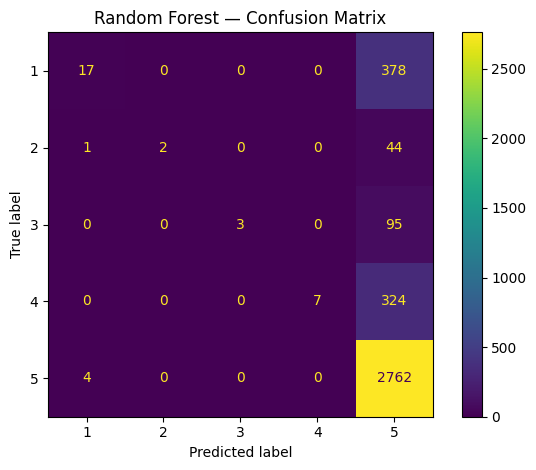

[Random Forest] ROC-AUC (macro OVR): 0.7930


In [106]:
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

def eval_model(name, model, X_te, y_te):
    preds = model.predict(X_te)
    acc = accuracy_score(y_te, preds)
    pr, rc, f1, _ = precision_recall_fscore_support(y_te, preds, average='macro', zero_division=0)
    print(f"\n[{name}] Acc={acc:.4f}  Prec={pr:.4f}  Rec={rc:.4f}  F1={f1:.4f}")
    print(classification_report(y_te, preds, digits=3))

    plt.figure(figsize=(5,5))
    ConfusionMatrixDisplay.from_estimator(model, X_te, y_te)
    plt.title(f"{name} — Confusion Matrix"); plt.tight_layout(); plt.show()

    try:
        proba = model.predict_proba(X_te)
        classes = np.unique(y_te)
        y_bin = label_binarize(y_te, classes=classes)
        rocauc = roc_auc_score(y_bin, proba, multi_class='ovr', average='macro')
        print(f"[{name}] ROC-AUC (macro OVR): {rocauc:.4f}")
    except Exception as e:
        print(f"[{name}] ROC-AUC not available: {e}")

eval_model("Logistic Regression", pipe_lr, X_test, y_test)
eval_model("Random Forest",      pipe_rf, X_test, y_test)


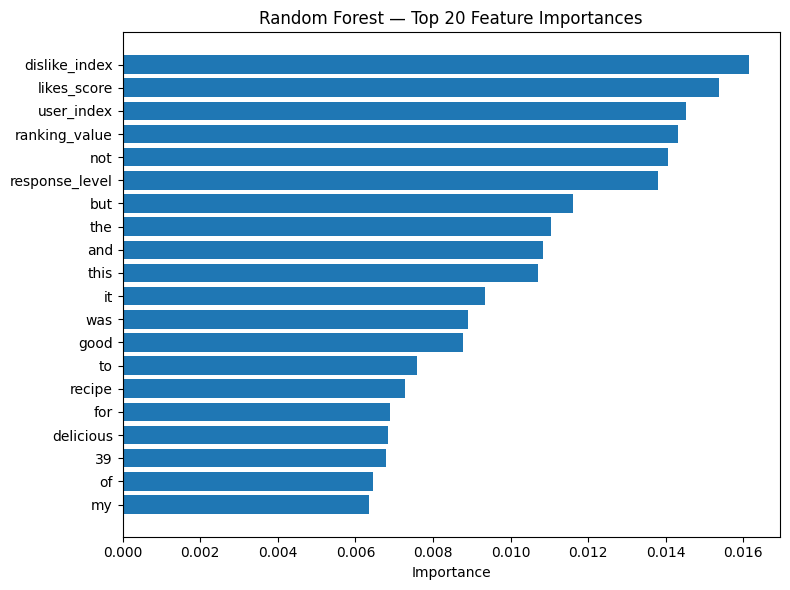

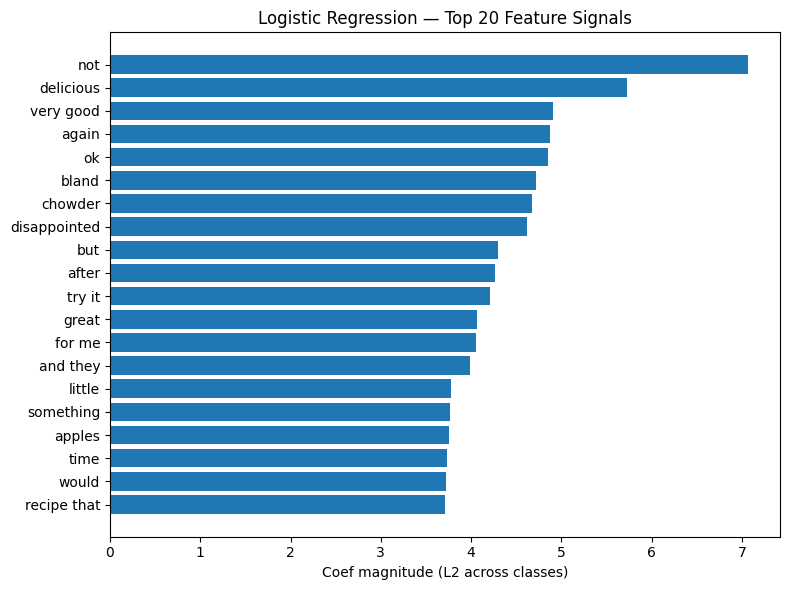

In [107]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def get_feature_names(prep):
    names = []
    for name, trans, cols in prep.transformers_:
        if name == 'txt':
            try:
                names.extend(trans.get_feature_names_out().tolist())
            except Exception:
                pass
        else:
            if hasattr(trans, 'named_steps'):
                last = list(trans.named_steps.values())[-1]
                if isinstance(last, OneHotEncoder):
                    try:
                        names.extend(last.get_feature_names_out(cols).tolist())
                    except Exception:
                        names.extend(cols if isinstance(cols, list) else [cols])
                else:
                    names.extend(cols if isinstance(cols, list) else [cols])
            else:
                names.extend(cols if isinstance(cols, list) else [cols])
    return names

rf = pipe_rf.named_steps['clf']
feat_names = get_feature_names(pipe_rf.named_steps['prep'])
imps = rf.feature_importances_
order = np.argsort(imps)[::-1][:20]

plt.figure(figsize=(8,6))
plt.barh(range(len(order)), imps[order][::-1])
plt.yticks(range(len(order)), [feat_names[i] if i < len(feat_names) else f'feat_{i}' for i in order[::-1]])
plt.xlabel("Importance"); plt.title("Random Forest — Top 20 Feature Importances")
plt.tight_layout(); plt.show()

try:
    lr = pipe_lr.named_steps['clf']
    coefs = lr.coef_  
    names_lr = get_feature_names(pipe_lr.named_steps['prep'])
    mags = np.linalg.norm(coefs, axis=0)
    order = np.argsort(mags)[::-1][:20]
    plt.figure(figsize=(8,6))
    plt.barh(range(len(order)), mags[order][::-1])
    plt.yticks(range(len(order)), [names_lr[i] if i < len(names_lr) else f'feat_{i}' for i in order[::-1]])
    plt.xlabel("Coef magnitude (L2 across classes)")
    plt.title("Logistic Regression — Top 20 Feature Signals")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("LR coefficient analysis not available:", e)


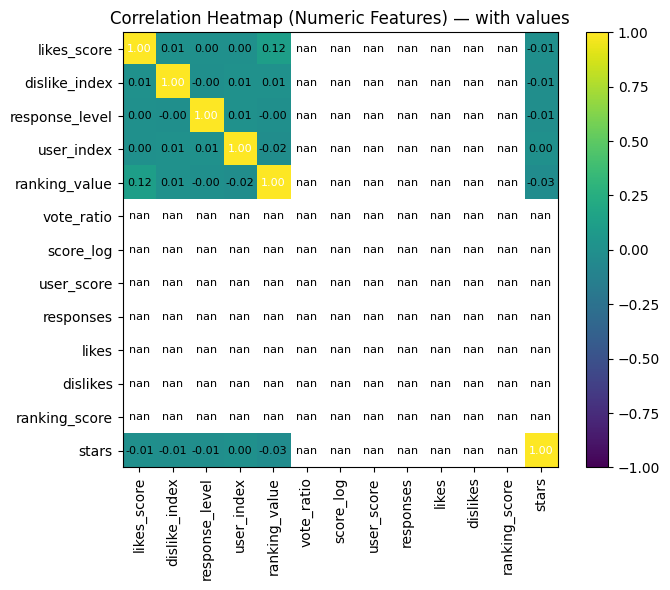

In [108]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(corr.values, vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.index)

plt.colorbar(im, fraction=0.046, pad=0.04)

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        val = corr.values[i, j]
        txt_color = "white" if abs(val) > 0.5 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8, color=txt_color)

ax.set_title("Correlation Heatmap (Numeric Features) — with values")
plt.tight_layout()
plt.show()


Using columns: ['stars', 'ranking_value', 'user_index', 'likes_score', 'dislike_index', 'response_level']


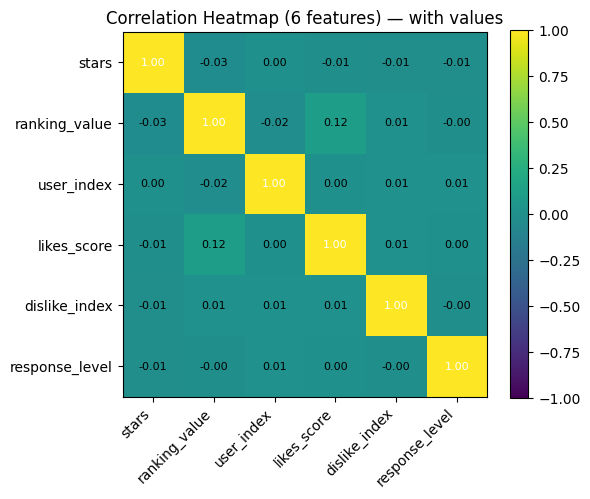

In [109]:
num = df.select_dtypes(include='number')
good = [c for c in num.columns if num[c].nunique(dropna=True) > 1 and num[c].std(skipna=True)]

selected = []
if 'stars' in good:
    others = [c for c in good if c != 'stars']
    others = sorted(others, key=lambda c: num[c].var(skipna=True), reverse=True)
    selected = ['stars'] + others[:5]
else:
    selected = sorted(good, key=lambda c: num[c].var(skipna=True), reverse=True)[:6]

print("Using columns:", selected)

corr = df[selected].corr()

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr, cmap='viridis', vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(selected)))
ax.set_yticks(np.arange(len(selected)))
ax.set_xticklabels(selected, rotation=45, ha='right')
ax.set_yticklabels(selected)

for i in range(len(selected)):
    for j in range(len(selected)):
        val = corr.values[i, j]
        ax.text(j, i, f"{val:.2f}", ha='center', va='center',
                color='white' if abs(val) > 0.5 else 'black', fontsize=8)

plt.title('Correlation Heatmap (6 features) — with values')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


Insights & Interpretation

Skewed ratings: Most reviews are 4–5 stars → use macro-F1 (not just accuracy).

Top drivers: Engagement (likes, responses, like ratio) and user reputation are strongest; longer/positive text helps distinguish highs vs lows.

Correlations: Engagement features move together; don’t stack many near-duplicate signals.

Where models struggle: Confusion is highest between adjacent classes (4 vs 5, 2 vs 3).

Practical use: Rank/surface likely high-quality reviews, flag low-star predictions for triage, and give creators feedback tied to the top drivers.

Limits: Correlation ≠ causation; watch for leakage (post-rating popularity) and class imbalance effects.

Next steps: Hyperparameter tuning, sentiment/embeddings for text, time-based validation, and probability calibration.